## Business Understanding
A new stealth tech company is building a new product. Having failed a previous attempt at covert corporate espionage, they have hired me to gather positive public comments made on Twitter about Google and Apple products to help them understand people's favorite aspects of those products to incorporate them into their new product. The tool will flag tweets as either positive or non-positive (could be neutral or negative) for deeper analysis. The company has stated that they would like to flag as many positive tweets as possible while minimizing false positives (tweets incorrectly labeled as positive).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from keras import metrics
import tensorflow as tf
from tensorflow.keras import backend as K

from nltk.corpus import stopwords
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import nltk
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mleroi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mleroi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Understanding

The csv file has ~9000 tweets, each labeled by a human as positive, neutral, or negative. ~1/3 are positive and ~2/3 are either neutral or negative. The accuracy of these labels is limited by the judgement of the humans who labeled the list, as well as the vagaries of emotion generally. Also, this data's applicability to current technology and language/slang may be limited by the fact that it is now over 10 years old.

In [2]:
# Read the csv file and display basic info
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


# Data Preparation

In [4]:
# Remove na's and duplicates
df.dropna(subset=['tweet_text'], inplace=True)
df.drop_duplicates(subset=['tweet_text'], inplace=True)

In [5]:
# Remove tweets that humans were unable to identify and create a flag for positive tweets
neg_neut_combine = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]
neg_neut_combine['pos_flag'] = 0
neg_neut_combine.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion', 'pos_flag'] = 1

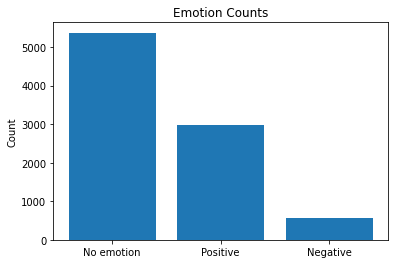

In [6]:
categories = ['No emotion', 'Positive', 'Negative']
total_emo_counts = neg_neut_combine['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

plt.bar(categories, total_emo_counts)
plt.ylabel('Count')
plt.title('Emotion Counts')
plt.show()

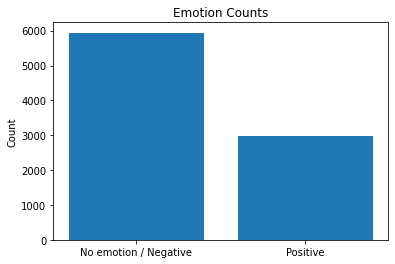

In [7]:
categories = ['No emotion / Negative', 'Positive']
neg_neut_emo_counts = neg_neut_combine['pos_flag'].value_counts()

plt.bar(categories, neg_neut_emo_counts)
plt.ylabel('Count')
plt.title('Emotion Counts')
plt.show()

In [8]:
# Create variables for X and y, to be split later
neg_neut_combine_tweets = neg_neut_combine['tweet_text'].copy()
neg_neut_combine_sentiment = neg_neut_combine['pos_flag'].copy()

In [9]:
# Split off test data to be used for final evaluation
X_train, X_test, y_train, y_test = train_test_split(neg_neut_combine_tweets,neg_neut_combine_sentiment, 
                                                    test_size=0.15, 
                                                    random_state=42, 
                                                    stratify=neg_neut_combine_sentiment)

In [10]:
# I use a function in the sequential model later that automatically uses the last 20% of 
# the entries for validation. I am manually splitting the training and validation data the same way 
# here for consistency. I verified that there is no significant difference in the proportion of positive 
# tweets between the training and validation sets.

X_train_baseline = X_train[:int(len(X_train) * 0.8)]
y_train_baseline = y_train[:int(len(y_train) * 0.8)]
X_val_baseline = X_train[-int(len(X_train) * 0.2):]
y_val_baseline = y_train[-int(len(y_train) * 0.2):]

# Modeling

### Baseline Model

I chose to use a TF-IDF vectorizer and logistic regression model as a straightforward first baseline model.

In [11]:
# Create a pipeline
clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('lr', LogisticRegression(max_iter=1000))
])

# Train
clf.fit(X_train_baseline, y_train_baseline)

# List most positive words
vectorizer = clf.named_steps["tfidf"]
classifier = clf.named_steps["lr"]

feature_names = vectorizer.get_feature_names_out()
coef = classifier.coef_[0]
top_pos_idx = coef.argsort()[-10:][::-1]
print("Top words for positive class:", feature_names[top_pos_idx])

# top_neg_idx = coef.argsort()[:10]
# print("Top words for negative/neutral class:", feature_names[top_neg_idx])

Top words for positive class: ['cool' 'great' 'ipad' 'good' 'love' 'wow' 'awesome' 'nice' 'excited'
 'fun']


In [12]:
# Get the F1 score from the validation set
ave_type = 'macro'
y_pred_val_base = clf.predict(X_val_baseline)
baseline_f1 = f1_score(y_val_baseline, y_pred_val_base, average=ave_type)
baseline_accuracy = accuracy_score(y_val_baseline, y_pred_val_base)
print(baseline_f1)

0.6466100474178859


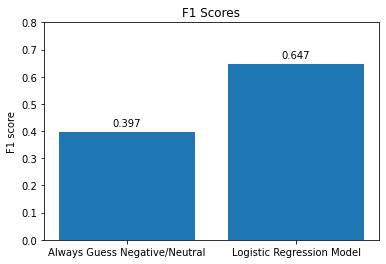

In [13]:
# Calculate comparison score based on always guessing majority class (negative/neutral)
y_pred2 = [0]*len(y_val_baseline)
majority_guess_f1 = f1_score(y_val_baseline, y_pred2, average=ave_type)
majority_guess_acc = accuracy_score(y_val_baseline, y_pred2)

categories = ['Always Guess Negative/Neutral', 'Logistic Regression Model']
f1s = [majority_guess_f1,baseline_f1]

plt.bar(categories, f1s)
plt.ylim(0, 0.8)
plt.ylabel('F1 score')
plt.title('F1 Scores')
for i, count in enumerate(f1s):
    plt.text(i, count+.02, str(round(count,3)), ha='center')
plt.show()

### Sequential Neural Network Model

This model was built to allow it to be called with multiple parameters specified and to be used for either a binary or multi-class classification, in case it was necessary to separate positive, neutral, and negative tweets. The run_pipe function takes in training data and parameters, then creates the pipeline, preps the data, trains the model, and returns the results.

In [14]:
def run_pipe(X,y, num_words=2000, 
             remove_stopwords=False, 
             lemmatize=False, 
             num_epochs=200, 
             show_results=False, 
             balance_classes=False):

# Compute weights to combat data imbalance, if necessary
    classes = np.unique(y)
    class_weights = [1]*len(classes)
    if balance_classes:
        class_weights = compute_class_weight(
            class_weight="balanced",
            classes=classes,
            y=y)
    class_weights = dict(zip(classes,class_weights))

# Text prep transformer

    class TextPrep(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.remove_stopwords = remove_stopwords
            self.lemmatize = lemmatize
            self.stop_words = set(stopwords.words("english"))
            self.lemmatizer = WordNetLemmatizer()

    # Map POS tag to WordNet format to help with lemmatization
        def get_wordnet_pos(self, treebank_tag):
            if treebank_tag.startswith("J"):
                return wordnet.ADJ
            elif treebank_tag.startswith("V"):
                return wordnet.VERB
            elif treebank_tag.startswith("N"):
                return wordnet.NOUN
            elif treebank_tag.startswith("R"):
                return wordnet.ADV
            else:
                return wordnet.NOUN

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            if isinstance(X, np.ndarray):
                X = X.ravel()
            X = [str(x) for x in X]

            processed = []
            for text in X:
                words = word_tokenize(text)

                # Remove stopwords, if desired
                if self.remove_stopwords:
                    words = [w for w in words if w.lower() not in self.stop_words]

                # Lemmatize, if desired
                if self.lemmatize:
                    pos_tags = pos_tag(words)
                    words = [self.lemmatizer.lemmatize(w, self.get_wordnet_pos(tag)) 
                             for w, tag in pos_tags]
                processed.append(" ".join(words))
            return processed        

    class KerasTokenizer(BaseEstimator, TransformerMixin):
        def __init__(self, mode="binary"):
            self.num_words = num_words
            self.mode = mode
            self.tokenizer = Tokenizer(num_words=self.num_words)

        def fit(self, X, y=None):
            self.tokenizer.fit_on_texts(X)
            return self

        def transform(self, X):
            return self.tokenizer.texts_to_matrix(X, mode=self.mode)    
      
 # Build sequential model

    def build_model(input_dim, n_classes):
        model = Sequential()
        model.add(Dense(50, activation="relu", input_shape=(input_dim,)))
        model.add(Dense(25, activation="relu"))
        model.add(Dense(n_classes, activation="softmax"))
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=['accuracy'],
            weighted_metrics=[]
        )
        return model

# Create pipeline

    n_classes = len(np.unique(y))

    pipeline = Pipeline([
        ("prep", TextPrep()),
        ("tok", KerasTokenizer()),
        ("clf", KerasClassifier(
            build_fn=lambda: build_model(
                input_dim=pipeline.named_steps["tok"].num_words, 
                n_classes=n_classes),
            epochs=num_epochs,
            batch_size=256,
            verbose=0,
            validation_split=0.2, 
            callbacks=[EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)],
            class_weight=class_weights))
    ])
    
# Fit
    pipeline.fit(X, y)

# Test results
    pipe_history = pipeline.named_steps["clf"].history_
    X_val = X[-int(len(X) * 0.2):]
    y_val = y[-int(len(y) * 0.2):]
    y_pred = pipeline.predict(X_val)
    pipe_f1 = f1_score(y_val, y_pred, average=ave_type)
    
   # Print more detailed results and extra plots if desired
    if show_results:
        print(confusion_matrix(y_val, y_pred))
        print("Max Val Accuracy:", max(pipe_history["val_accuracy"]))
        print("F1 score: ", pipe_f1)
        plt.figure(figsize=(8,5))
        plt.plot(pipe_history["accuracy"], label="Train Accuracy")
        if "val_accuracy" in pipe_history:
            plt.plot(pipe_history["val_accuracy"], label="Validation Accuracy")
        plt.title("Epoch vs Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
    
    return max(pipe_history["val_accuracy"]), pipe_f1, pipeline;

This function gets the most predictive words for each class. It returns the words and their weights.

In [15]:
def get_top_words_by_model_weights(pipeline, top_n=10):

    tok = pipeline.named_steps["tok"].tokenizer
    vocab_size = tok.num_words
    word_index = tok.word_index
    inv_word_index = {v: k for k, v in word_index.items() if v < vocab_size}

    model = pipeline.named_steps["clf"].model_
    first_dense = model.layers[0]
    second_dense = model.layers[1]
    final_dense = model.layers[-1]
    
    # Get weights for each layer
    W1, b1 = first_dense.get_weights()
    W2, b2 = second_dense.get_weights()
    W3, b3 = final_dense.get_weights()
    
    # Calculate combined weights
    combined_weights = W1 @ W2 @ W3

    top_words = {}
    for class_idx in range(combined_weights.shape[1]):
        class_contrib = combined_weights[:, class_idx]
        top_indices = np.argsort(class_contrib)[-top_n:][::-1]

        top_words[class_idx] = [
            (inv_word_index.get(i, f"<UNK_{i}>"), class_contrib[i])
            for i in top_indices]

    return top_words

This function calls the run_pipe function multiple times with different parameters and stores the results. Creating my own function, rather than using GridSearchCV, allowed me to customize the inputs, outputs, and displays (prints and plots) throughout the process.

In [16]:
def parameter_check (X_par, y_par, num_words_list, plot=True, balance_classes=False, show_results=False):
    
    results=pd.DataFrame(columns=["number_of_words","val_accuracy", 'remove_stopwords', 'lemmatize', 'f1'])
    i=1
    stop_tf=False
    lem_tf=False
    best_f1 = 0
    
# This will run once per parameter combination by default. To loop on j to run multiple times and average the results,
# uncomment the line: "for j in range(3):", then indent the block between the lines.

#     for j in range(3):

#--------------------------------------------------------------------#
    for x in num_words_list:
        for stop_tf in [False,True]:
            for lem_tf in [False,True]:
                acc, f1, model=run_pipe(X_par,y_par, 
                                 num_words=x,
                                 remove_stopwords=stop_tf, 
                                 lemmatize=lem_tf, 
                                 balance_classes=balance_classes, 
                                 show_results=show_results)
                if f1>best_f1:
                    best_f1=f1
                    best_model=model
                
                print(f'({i} of {len(num_words_list)*4}) Stopwords: {stop_tf}, Lemmatize: {lem_tf}, Number of words: {x}, Val accuracy: {round(acc,4)}, F1 score: {round(f1,4)}')
                new_row_data = {'number_of_words': [x], 'val_accuracy': [acc], 'remove_stopwords': [stop_tf], 'lemmatize': [lem_tf], 'f1': [f1]}
                new_row = pd.DataFrame(new_row_data)
                results = pd.concat([results,new_row], ignore_index=True)
                i += 1
    results["config"] = results.apply(
        lambda row: f"Stopwords={row['remove_stopwords']}, Lemmatize={row['lemmatize']}", axis=1)
#--------------------------------------------------------------------#

    for num_word in num_words_list:
        baseline_row_data = {'number_of_words': [num_word], 'val_accuracy': [baseline_accuracy], 'f1': [baseline_f1], 'config': 'Baseline Linear Regression Model'}
        baseline_rows = pd.DataFrame(baseline_row_data)
        results = pd.concat([results,baseline_rows], ignore_index=True)
    results = results.sort_values("number_of_words")

    if plot:
        avg_data = results.groupby(["number_of_words", "config"], as_index=False)["f1"].mean()        
        fig, ax2 = plt.subplots(figsize=(10,6))
        sns.lineplot(
            data=avg_data,
            x="number_of_words",
            y="f1",
            hue="config",
            style="config",
            ax=ax2,
            markers=True,
            dashes=True)
        plt.title("Validation F1 Score vs Number of Words", fontsize=14)
        plt.xlabel("Number of Words", fontsize=12)
        plt.ylabel("Validation F1 Score", fontsize=12)
        plt.legend(title="Preprocessing Config")
        plt.grid(True, alpha=0.3)
        plt.show()
        
    return results, best_model

(1 of 4) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.7221, F1 score: 0.6657
(2 of 4) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.7234, F1 score: 0.629
(3 of 4) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.7254, F1 score: 0.6612
(4 of 4) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.7162, F1 score: 0.6399


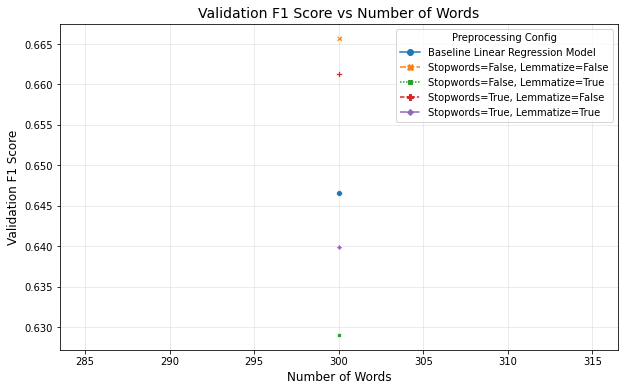

In [17]:
num_words_list = [300]
unweighted_results, unweighted_model = parameter_check(X_train,y_train, num_words_list, show_results=False)

In [18]:
uw_pred = unweighted_model.predict(X_test)
f1_score(y_test, uw_pred, average=ave_type)

0.6387094934439942

In [19]:
top_words = get_top_words_by_model_weights(unweighted_model, top_n=10)

for cls, words in top_words.items():
    print(f"\nTop words for class {cls}:")
    for word, weight in words:
        print(f"{word:15s} ({weight:.2f})")


Top words for class 0:
he              (4.05)
relief          (4.04)
because         (3.37)
rumor           (2.87)
many            (2.78)
12              (2.74)
yet             (2.70)
launching       (2.46)
says            (2.44)
11              (2.39)

Top words for class 1:
nice            (3.57)
great           (3.42)
fun             (2.80)
ipad            (2.65)
good            (2.61)
better          (2.39)
awesome         (2.33)
yes             (2.23)
love            (2.08)
available       (2.01)


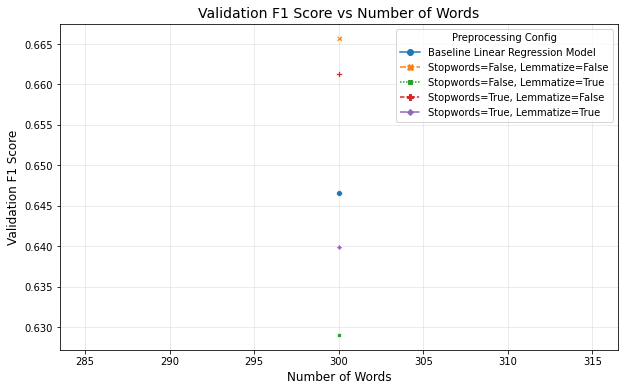

Highest F1 score: 0.666


In [20]:
avg_data = unweighted_results.groupby(["number_of_words", "config"], as_index=False)["f1"].mean()        

fig, ax2 = plt.subplots(figsize=(10,6))

sns.lineplot(
    data=avg_data,
    x="number_of_words",
    y="f1",
    hue="config",
    style="config",
    ax=ax2,
    markers=True,
    dashes=True)
plt.title("Validation F1 Score vs Number of Words", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Validation F1 Score", fontsize=12)
plt.legend(title="Preprocessing Config")
plt.grid(True, alpha=0.3)
plt.show()
print(f"""Highest F1 score: {round(avg_data['f1'].max(),3)}""")

(1 of 4) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.695, F1 score: 0.665
(2 of 4) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.6891, F1 score: 0.6606
(3 of 4) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.7201, F1 score: 0.6866
(4 of 4) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.701, F1 score: 0.6693


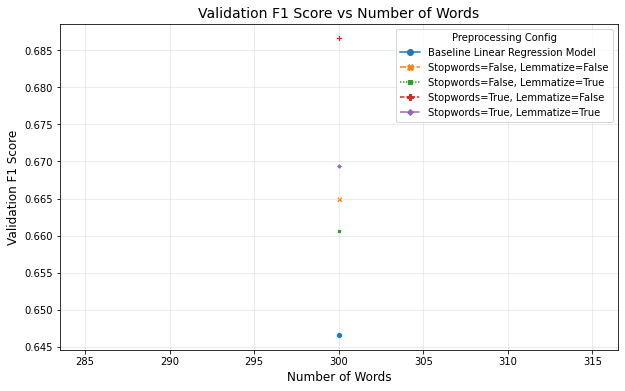

In [21]:
num_words_list = [300]
weighted_results, weighted_model = parameter_check(X_train,y_train, num_words_list, balance_classes=True, show_results=False)

In [22]:
top_words = get_top_words_by_model_weights(weighted_model, top_n=10)

for cls, words in top_words.items():
    print(f"\nTop words for class {cls}:")
    for word, weight in words:
        print(f"{word:15s} ({weight:.2f})")


Top words for class 0:
money           (2.21)
codes           (2.11)
00              (1.87)
12              (1.67)
something       (1.52)
11              (1.50)
anyone          (1.49)
please          (1.49)
twitter         (1.48)
30              (1.48)

Top words for class 1:
awesome         (2.01)
good            (1.91)
cool            (1.91)
amazing         (1.85)
smart           (1.77)
wow             (1.77)
must            (1.69)
great           (1.64)
nice            (1.48)
fun             (1.45)


# Evaluation

In [24]:
weight_pred = weighted_model.predict(X_test)
f1_score(y_test, weight_pred, average=ave_type)

0.6462066642467155

In [25]:
confusion_matrix(y_test, weight_pred)

array([[669, 223],
       [202, 243]], dtype=int64)

In [26]:
y_test.value_counts()

0    892
1    445
Name: pos_flag, dtype: int64

In [27]:
print(f'{1/precision_score(weight_pred, y_test)}')

1.8312757201646088


In [28]:
(445+892)/445

3.004494382022472

In [29]:
3/1.862


1.6111707841031149

In [30]:
import pandas as pd
import re

data = """
(1 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.6878, F1 score: 0.6422
[[792 204]
 [249 269]]
(2 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.701, F1 score: 0.6603
[[741 255]
 [188 330]]
(3 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.7076, F1 score: 0.6841
[[753 243]
 [219 299]]
(4 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.695, F1 score: 0.6647
[[781 215]
 [190 328]]
(5 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7327, F1 score: 0.7062
[[765 231]
 [203 315]]
(6 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7135, F1 score: 0.6856
[[772 224]
 [189 329]]
(7 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7274, F1 score: 0.7017
[[767 229]
 [199 319]]
(8 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7175, F1 score: 0.6902
[[821 175]
 [228 290]]
(9 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.734, F1 score: 0.6965
[[789 207]
 [202 316]]
(10 of 20) Stopwords: False, Lemmatize: True, Number of words: 2000, Val accuracy: 0.73, F1 score: 0.7006
[[811 185]
 [213 305]]
(11 of 20) Stopwords: True, Lemmatize: False, Number of words: 2000, Val accuracy: 0.7373, F1 score: 0.7041
[[817 179]
 [222 296]]
(12 of 20) Stopwords: True, Lemmatize: True, Number of words: 2000, Val accuracy: 0.7353, F1 score: 0.6996
[[819 177]
 [219 299]]
(13 of 20) Stopwords: False, Lemmatize: False, Number of words: 5000, Val accuracy: 0.7386, F1 score: 0.7035
[[783 213]
 [184 334]]
(14 of 20) Stopwords: False, Lemmatize: True, Number of words: 5000, Val accuracy: 0.738, F1 score: 0.7125
[[821 175]
 [216 302]]
(15 of 20) Stopwords: True, Lemmatize: False, Number of words: 5000, Val accuracy: 0.7419, F1 score: 0.7074
[[822 174]
 [238 280]]
(16 of 20) Stopwords: True, Lemmatize: True, Number of words: 5000, Val accuracy: 0.7281, F1 score: 0.6879
[[844 152]
 [240 278]]
(17 of 20) Stopwords: False, Lemmatize: False, Number of words: 10000, Val accuracy: 0.7413, F1 score: 0.699
[[832 164]
 [226 292]]
(18 of 20) Stopwords: False, Lemmatize: True, Number of words: 10000, Val accuracy: 0.7426, F1 score: 0.7049
[[822 174]
 [219 299]]
(19 of 20) Stopwords: True, Lemmatize: False, Number of words: 10000, Val accuracy: 0.7406, F1 score: 0.7053
[[810 186]
 [223 295]]
(20 of 20) Stopwords: True, Lemmatize: True, Number of words: 10000, Val accuracy: 0.73, F1 score: 0.6945
[[776 220]
 [251 267]]
(21 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.6891, F1 score: 0.6493
[[761 235]
 [224 294]]
(22 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.697, F1 score: 0.665
[[742 254]
 [201 317]]
(23 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.6997, F1 score: 0.6738
[[794 202]
 [225 293]]
(24 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.7182, F1 score: 0.6833
[[786 210]
 [206 312]]
(25 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7254, F1 score: 0.6954
[[795 201]
 [226 292]]
(26 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7182, F1 score: 0.683
[[793 203]
 [225 293]]
(27 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7175, F1 score: 0.6827
[[768 228]
 [207 311]]
(28 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7129, F1 score: 0.6839
[[816 180]
 [224 294]]
(29 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.7333, F1 score: 0.6972
[[823 173]
 [231 287]]
(30 of 20) Stopwords: False, Lemmatize: True, Number of words: 2000, Val accuracy: 0.7333, F1 score: 0.6949
[[798 198]
 [204 314]]
(31 of 20) Stopwords: True, Lemmatize: False, Number of words: 2000, Val accuracy: 0.7347, F1 score: 0.7043
[[812 184]
 [233 285]]
(32 of 20) Stopwords: True, Lemmatize: True, Number of words: 2000, Val accuracy: 0.7248, F1 score: 0.6866
[[813 183]
 [214 304]]
(33 of 20) Stopwords: False, Lemmatize: False, Number of words: 5000, Val accuracy: 0.738, F1 score: 0.7044
[[814 182]
 [217 301]]
(34 of 20) Stopwords: False, Lemmatize: True, Number of words: 5000, Val accuracy: 0.7366, F1 score: 0.7023
[[819 177]
 [223 295]]
(35 of 20) Stopwords: True, Lemmatize: False, Number of words: 5000, Val accuracy: 0.736, F1 score: 0.6998
[[828 168]
 [222 296]]
(36 of 20) Stopwords: True, Lemmatize: True, Number of words: 5000, Val accuracy: 0.7426, F1 score: 0.7061
[[800 196]
 [208 310]]
(37 of 20) Stopwords: False, Lemmatize: False, Number of words: 10000, Val accuracy: 0.7333, F1 score: 0.7019
[[811 185]
 [214 304]]
(38 of 20) Stopwords: False, Lemmatize: True, Number of words: 10000, Val accuracy: 0.7366, F1 score: 0.7032
[[826 170]
 [229 289]]
(39 of 20) Stopwords: True, Lemmatize: False, Number of words: 10000, Val accuracy: 0.7366, F1 score: 0.6985
[[759 237]
 [171 347]]
(40 of 20) Stopwords: True, Lemmatize: True, Number of words: 10000, Val accuracy: 0.7307, F1 score: 0.709
[[765 231]
 [234 284]]
(41 of 20) Stopwords: False, Lemmatize: False, Number of words: 300, Val accuracy: 0.6931, F1 score: 0.6584
[[792 204]
 [248 270]]
(42 of 20) Stopwords: False, Lemmatize: True, Number of words: 300, Val accuracy: 0.7017, F1 score: 0.6612
[[769 227]
 [203 315]]
(43 of 20) Stopwords: True, Lemmatize: False, Number of words: 300, Val accuracy: 0.7162, F1 score: 0.6879
[[788 208]
 [237 281]]
(44 of 20) Stopwords: True, Lemmatize: True, Number of words: 300, Val accuracy: 0.7063, F1 score: 0.669
[[850 146]
 [273 245]]
(45 of 20) Stopwords: False, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7234, F1 score: 0.6707
[[769 227]
 [199 319]]
(46 of 20) Stopwords: False, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7188, F1 score: 0.6914
[[757 239]
 [195 323]]
(47 of 20) Stopwords: True, Lemmatize: False, Number of words: 1000, Val accuracy: 0.7135, F1 score: 0.6877
[[779 217]
 [207 311]]
(48 of 20) Stopwords: True, Lemmatize: True, Number of words: 1000, Val accuracy: 0.7201, F1 score: 0.6904
[[808 188]
 [219 299]]
(49 of 20) Stopwords: False, Lemmatize: False, Number of words: 2000, Val accuracy: 0.7314, F1 score: 0.6969
[[788 208]
 [213 305]]
(50 of 20) Stopwords: False, Lemmatize: True, Number of words: 2000, Val accuracy: 0.7221, F1 score: 0.6904
[[809 187]
 [233 285]]
(51 of 20) Stopwords: True, Lemmatize: False, Number of words: 2000, Val accuracy: 0.7228, F1 score: 0.6848
[[813 183]
 [235 283]]
(52 of 20) Stopwords: True, Lemmatize: True, Number of words: 2000, Val accuracy: 0.7241, F1 score: 0.6854
[[815 181]
 [211 307]]
(53 of 20) Stopwords: False, Lemmatize: False, Number of words: 5000, Val accuracy: 0.7413, F1 score: 0.7082
[[746 250]
 [177 341]]
(54 of 20) Stopwords: False, Lemmatize: True, Number of words: 5000, Val accuracy: 0.7182, F1 score: 0.6962
[[832 164]
 [227 291]]
(55 of 20) Stopwords: True, Lemmatize: False, Number of words: 5000, Val accuracy: 0.7419, F1 score: 0.7039
[[835 161]
 [240 278]]
(56 of 20) Stopwords: True, Lemmatize: True, Number of words: 5000, Val accuracy: 0.7353, F1 score: 0.6937
[[818 178]
 [218 300]]
(57 of 20) Stopwords: False, Lemmatize: False, Number of words: 10000, Val accuracy: 0.7386, F1 score: 0.7038
[[803 193]
 [212 306]]
(58 of 20) Stopwords: False, Lemmatize: True, Number of words: 10000, Val accuracy: 0.7327, F1 score: 0.7002
[[796 200]
 [198 320]]
(59 of 20) Stopwords: True, Lemmatize: False, Number of words: 10000, Val accuracy: 0.7373, F1 score: 0.7083
[[814 182]
 [224 294]]
(60 of 20) Stopwords: True, Lemmatize: True, Number of words: 10000, Val accuracy: 0.732, F1 score: 0.696
"""       
                    
                    
pattern = re.compile(
    r"Stopwords:\s*(True|False),\s*Lemmatize:\s*(True|False),\s*Number of words:\s*(\d+),\s*Val accuracy:\s*([\d.]+),\s*F1 score:\s*([\d.]+)"
)

rows = []
for match in pattern.finditer(data):
    remove_stopwords = match.group(1) == "True"
    lemmatize = match.group(2) == "True"
    number_of_words = int(match.group(3))
    val_accuracy = float(match.group(4))
    f1 = float(match.group(5))
    config = f"Stopwords={remove_stopwords}, Lemmatize={lemmatize}"

    rows.append({
        "number_of_words": number_of_words,
        "val_accuracy": val_accuracy,
        "remove_stopwords": remove_stopwords,
        "lemmatize": lemmatize,
        "f1": f1,
        "config": config
    })

dfw = pd.DataFrame(rows)
for num_word in num_words_list:
    baseline_row_data = {'number_of_words': [num_word], 'val_accuracy': [baseline_accuracy], 'f1': [baseline_f1], 'config': 'Baseline Linear Regression Model'}
    baseline_rows = pd.DataFrame(baseline_row_data)
    dfw = pd.concat([dfw,baseline_rows], ignore_index=True)
print(dfw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number_of_words   61 non-null     int64  
 1   val_accuracy      61 non-null     float64
 2   remove_stopwords  60 non-null     object 
 3   lemmatize         60 non-null     object 
 4   f1                61 non-null     float64
 5   config            61 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 3.0+ KB
None


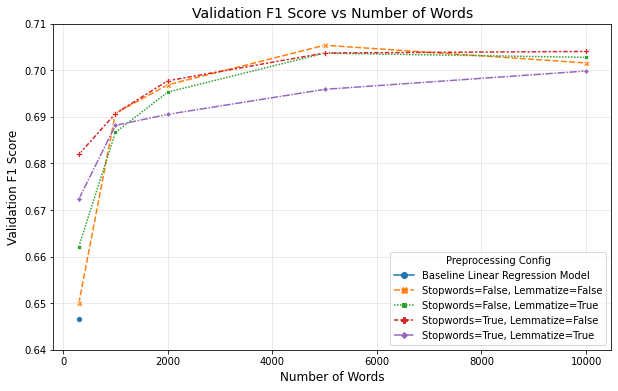

0.7053666666666668

In [31]:
avg_dataw = dfw.groupby(["number_of_words", "config"], as_index=False)["f1"].mean()        

fig, ax2 = plt.subplots(figsize=(10,6))

sns.lineplot(
    data=avg_dataw,
    x="number_of_words",
    y="f1",
    hue="config",
    style="config",
    ax=ax2,
    markers=True,
    dashes=True)
plt.ylim(0.64, 0.71)
plt.title("Validation F1 Score vs Number of Words", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Validation F1 Score", fontsize=12)
plt.legend(title="Preprocessing Config")
plt.grid(True, alpha=0.3)
plt.show()

avg_dataw['f1'].max()

[[153  26]
 [ 49  39]]
Max Val Accuracy: 0.7164179086685181
F1 score:  0.65647676393392


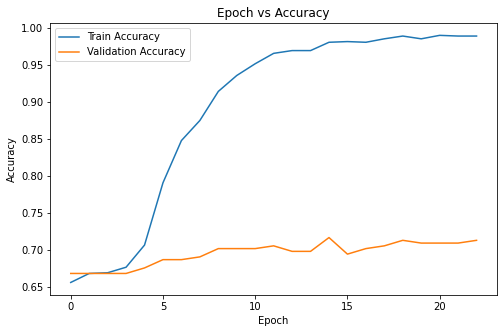

(0.7164179086685181,
 0.65647676393392,
 Pipeline(steps=[('prep', TextPrep()), ('tok', KerasTokenizer()),
                 ('clf',
                  KerasClassifier(batch_size=256, build_fn=<function run_pipe.<locals>.<lambda> at 0x000001C239A290D0>, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x000001C237894700>], class_weight={0: 1, 1: 1}, epochs=300, validation_split=0.2, verbose=0))]))

In [36]:
run_pipe(X_test,y_test, num_words=5000, num_epochs=300, remove_stopwords=False, lemmatize=True, show_results=True)